#### Possible new features:
- Ratio of times user got answer right on first attempt - Not important
- Ratio of times question was answered right on first attempt - Not important
- lectures seen cumsum / ratio of lectures in content - Not important  

- Ratio of explanation check when user gets answer wrong (check if mean accuracy for that container <1) - Done (Shows lower results during submission)
- Ratio of explanation check when user gets answer right (check if mean accuracy for that container==1) - Done
- Difference between the 2 ratios - Done (checking importance on submission)
- Mark if any lectures have been watched in the past given number of container ids - Done
  
- Time difference between the lectures watched and when question was attempted - Done (Lalu)
- Time difference between repeated questions - saving timestamp for each (user, content) too memory intensive
- Average time difference while handling the timestamp difference of hours  

- No of breaks the user has taken. Breaks = when lag_timestamp > 8 hrs - Done
- average time spent per seating (how to define a seating?) More focused students would spend longer durations at a seating - Done
- Modify seen explanation by the time difference between the question lag_timestamp and prior_question_elapsed_time
- Median time spent by students in seeing the explanation of that question
- How to give stats of distribution of timestamp by a student - (Tried var and skew) - Done
- Variance of last 30 timestamps? - Done
- Rolling accuracy of the student - Done
- Size of the task container - Done

- Can we predict the time taken by the user based on the lag_timestamp and the average time difference on that question for explanation seen and not seen (Previous task containers seen_explanation could be used to predict next seen explanation)
- Try to search if theres a automatic log out time for a session in case of inactivity

In [1]:
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl

Processing /kaggle/input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl


In [2]:
import datatable as dt
import pandas as pd
import numpy as np
import random
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
from tqdm.notebook import tqdm
import pickle
from sklearn.metrics import roc_auc_score

pd.options.mode.chained_assignment = None
_ = np.seterr(divide='ignore', invalid='ignore')
pd.set_option('display.max_columns', None)
# pd.set_option('display.float_format', lambda x: '%.1f' % x)

In [3]:
# Memory status
# psutil.virtual_memory()

# Variable list and memory consumption
# import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                          key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

In [4]:
with open("../input/riiid-education/new_questions.pickle",'rb') as handle:
    quest_dict = pickle.load(handle)
questions = pd.DataFrame(quest_dict)
questions = questions.astype({'part':'uint8','qn_part_accuracy':'float32','qn_tag_accuracy':'float32',
                            'qn_count':'uint32','qn_expln_check':'float32','qn_median_elapsed_time':'uint32',
                            'qn_right_ans':'float32','rows':'uint8','part_bundle_id':'uint32'})

In [10]:
questions_csv = dt.fread("../input/riiid-test-answer-prediction/questions.csv").to_pandas()
questions['bundle_id'] = questions_csv['bundle_id'].astype('uint16')

del questions_csv
gc.collect()

# questions['part_bundle_id']=(questions['part']*100000+questions['bundle_id']).astype('uint32')

0

In [12]:
data_types = {
#     'row_id': 'int32',
    'timestamp': 'float64',
    'user_id': 'uint32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    'task_container_id': 'uint16',
#     'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'boolean'
}

In [13]:
data = dt.fread("../input/riiid-test-answer-prediction/train.csv",
               columns=set(data_types.keys())).to_pandas()

print("Train size:", data.shape)

Train size: (101230332, 8)


In [14]:
data = data.astype(data_types)

In [15]:
# timestamp_dict = data[['user_id','timestamp']].groupby('user_id').tail(1)
# timestamp_dict.set_index('user_id',inplace=True)
# t_dict = timestamp_dict.to_dict()
# with open('timestamp_dict.pkl','wb') as handle:
#     pickle.dump(t_dict,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
mean_elapsed_time = round(data['prior_question_elapsed_time'].median())
mean_accuracy = data['answered_correctly'].mean()

In [17]:
random.seed(42)
data = data[data.user_id.isin(random.sample(set(data.user_id.unique()), data.user_id.nunique()//5))]

In [18]:
# save_data = data.copy()
# data = save_data.copy()

In [19]:
data.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
76,0.0,2746,5273,0,0,0,NaN,<NA>
77,21592.0,2746,758,0,1,0,28000.0,False
78,49069.0,2746,5976,0,2,0,17000.0,False
79,72254.0,2746,236,0,3,1,24000.0,False
80,91945.0,2746,404,0,4,0,20000.0,False


In [20]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20068085 entries, 76 to 101230024
Data columns (total 8 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       float64
 1   user_id                         uint32 
 2   content_id                      int16  
 3   content_type_id                 int8   
 4   task_container_id               uint16 
 5   answered_correctly              int8   
 6   prior_question_elapsed_time     float32
 7   prior_question_had_explanation  boolean
dtypes: boolean(1), float32(1), float64(1), int16(1), int8(2), uint16(1), uint32(1)
memory usage: 612.4 MB


In [21]:
questions.head()

,part,qn_part_accuracy,qn_tag_accuracy,qn_count,qn_expln_check,qn_median_elapsed_time,qn_right_ans,rows,part_bundle_id,bundle_id
0,1,0.745117,0.731934,6913,6576.498535,131367,6273.094238,1,100000,0
1,1,0.745117,0.728027,7408,7255.498535,148170,6596.094238,1,100001,1
2,1,0.745117,0.714844,44915,40430.500000,1033025,24897.093750,1,100002,2
3,1,0.745117,0.729004,22983,22218.498047,482643,17913.093750,1,100003,3
4,1,0.745117,0.731445,31746,16902.498047,666666,19468.093750,1,100004,4


### Generating features

In [22]:
# mean_elapsed_time = round(data['prior_question_elapsed_time'].mean())
# mean_accuracy = data['answered_correctly'].mean()

In [23]:
temp = data.groupby(['user_id','task_container_id'],sort=False).agg(
    {'prior_question_elapsed_time':'first','prior_question_had_explanation':'first','timestamp':'first',
     'content_type_id':'first','content_id':'size','answered_correctly':'mean'}).reset_index()
temp.rename(columns={'content_id':'rows'},inplace=True)

temp['lag_timestamp'] = temp.groupby('user_id')['timestamp'].shift()
temp['lag_timestamp'] = temp['timestamp']- temp['lag_timestamp']
temp['lag_timestamp'].fillna(25589,inplace=True)
temp['lag_timestamp'] = (temp['lag_timestamp']/(3600*1000)).astype('float32')
## lag_timestamp.median = 25589

In [24]:
temp['lag_timestamp2'] = temp.groupby('user_id')['timestamp'].shift(2)
temp['lag_timestamp2'] = temp['timestamp']- temp['lag_timestamp2']
temp['lag_timestamp2'].fillna(53351,inplace=True)
temp['lag_timestamp2'] = (temp['lag_timestamp2']/(3600*1000)).astype('float32')
# lag_timestamp2.median = 53351

In [25]:
temp['lag_timestamp3'] = temp.groupby('user_id')['timestamp'].shift(3)
temp['lag_timestamp3'] = temp['timestamp']- temp['lag_timestamp3']
temp['lag_timestamp3'].fillna(78124,inplace=True)
temp['lag_timestamp3'] = (temp['lag_timestamp3']/(3600*1000)).astype('float32')
# lag_timestamp3.median = 78124

In [26]:
# temp['lag_timestamp_hr'] = (temp['lag_timestamp']//(60*60*1000)).astype('uint16')
# temp['new_session'] = (temp.lag_timestamp_hr>2).astype('uint8')
# temp['new_session'] = temp.groupby('user_id')['new_session'].cumsum()+1
# temp2 = temp.groupby(['user_id','new_session'],as_index=False,sort=False).agg(content_solved=('rows','sum'),min_time=('timestamp','first'),
#                                                     max_time=('timestamp','last'),repeat =('timestamp','size'))
# temp2['time_spent'] = temp2['max_time']-temp2['min_time']
# temp2['cum_time_spent'] = temp2.groupby('user_id')['time_spent'].cumsum()
# temp2['avg_time_spent'] = temp2['cum_time_spent']/temp2['new_session']
# temp2['cum_content_solved'] = temp2.groupby('user_id')['content_solved'].cumsum()
# temp2['avg_content_solved'] = temp2['cum_content_solved']/temp2['new_session']

# mean_content_solved = temp2.groupby('user_id')['cum_content_solved'].head(1).median()
# mean_time_spent = temp2.groupby('user_id')['cum_time_spent'].head(1).median()

# temp2['prev_content_solved_avg'] = temp2.groupby('user_id')['avg_content_solved'].shift()
# temp2['prev_time_spent_avg'] = temp2.groupby('user_id')['avg_time_spent'].shift()

# temp2 = temp2.drop(columns = ['min_time','max_time','avg_time_spent','cum_content_solved','avg_content_solved',
#                              'user_id','new_session','content_solved','cum_time_spent','time_spent'])
# temp2 = temp2.fillna({'prev_content_solved_avg':mean_content_solved,
#                      'prev_time_spent_avg':mean_time_spent})
# temp2 = temp2.astype({'prev_content_solved_avg':'float32','prev_time_spent_avg':'uint32'})

# temp2 = temp2.reindex(temp2.index.repeat(temp2.repeat)).reset_index(drop=True)
# temp2.index = temp.index
# temp2 = temp2.drop(columns='repeat')
# temp = pd.concat([temp,temp2],axis=1)

# del temp2
# gc.collect()

In [27]:
## LECTURE PROXIMITY FEATURES

temp['lecture_in_1'] = temp[['user_id','content_type_id']].groupby('user_id')['content_type_id'].shift(1).fillna(0).astype('uint8')
temp['lecture_in_2'] = temp[['user_id','content_type_id']].groupby('user_id')['content_type_id'].shift(2).fillna(0).astype('uint8')

temp['lecture_in_2'] += temp['lecture_in_1']
temp['lecture_in_2'] = (temp['lecture_in_2']>0).astype('uint8')

temp =  temp.drop(columns='lecture_in_1')

In [28]:
temp['timestamp_day'] = temp['timestamp']/(1000*60*60*24)

In [29]:
temp['ans_var_15_day'] = temp.groupby('user_id')['timestamp_day'].transform(lambda x:x.rolling(15,5).var())
temp['ans_var_15_day'] = temp.groupby('user_id')['ans_var_15_day'].shift()
temp['ans_var_15_day'] = temp['ans_var_15_day'].fillna(3.8677079787433557e-07)
temp['ans_var_15_day'] = temp['ans_var_15_day'].astype('float32')

# ans_var_15_day median = 3.8677079787433557e-07

In [30]:
# temp['ans_var_30_day'] = temp.groupby('user_id')['timestamp_day'].transform(lambda x:x.rolling(30,5).var())
# temp['ans_var_30_day'] = temp.groupby('user_id')['ans_var_30_day'].shift()
# temp['ans_var_30_day'] = temp['ans_var_30_day'].fillna(temp['ans_var_30_day'].median())

# temp['ans_skew_15_day'] = temp.groupby('user_id')['timestamp_day'].transform(lambda x:x.rolling(15,5).skew())
# temp['ans_skew_15_day'] = temp.groupby('user_id')['ans_skew_15_day'].shift()
# temp['ans_skew_15_day'] = temp['ans_skew_15_day'].fillna(temp['ans_skew_15_day'].median())

# temp['ans_skew_30_day'] = temp.groupby('user_id')['timestamp_day'].transform(lambda x:x.rolling(30,5).skew())
# temp['ans_skew_30_day'] = temp.groupby('user_id')['ans_skew_30_day'].shift()
# temp['ans_skew_30_day'] = temp['ans_skew_30_day'].fillna(temp['ans_skew_30_day'].median())

In [31]:
# temp['timestamp_day'] = temp['timestamp_day'].astype('uint16') +1
# temp2 = temp[['user_id','timestamp_day']].groupby(['user_id','timestamp_day'],as_index=False,sort=False).agg(count = ('timestamp_day','count'))
# temp2['days_attended'] = (temp2.groupby('user_id').cumcount()+1).astype('uint16')
# temp2.drop(columns = ['user_id','timestamp_day'],inplace=True)
# temp2 = temp2.reindex(temp2.index.repeat(temp2['count'])).reset_index(drop=True)
# temp2.index = temp.index

# # temp.drop(columns = 'rows', inplace=True)
# temp = pd.concat([temp,temp2[['days_attended']]],axis=1)

# del temp2
# gc.collect()
# temp['frac_days_attended'] = (temp['days_attended']/temp['timestamp_day']).astype('float32')

In [32]:
temp = temp.drop(columns='timestamp_day')
gc.collect()

60

In [33]:
# temp['lectures_seen'] = temp[['user_id','content_type_id']].groupby('user_id')['content_type_id'].cumsum().shift().fillna(0).astype('uint16')
# temp['lectures_frac'] = temp[['user_id','task_container_id']].groupby('user_id')['task_container_id'].cumcount().astype('uint16')
# temp['lectures_frac'] = (temp['lectures_seen']/temp['lectures_frac']).fillna(0).astype('float32')

In [34]:
temp = temp.loc[temp.content_type_id==0].drop(columns='content_type_id')

In [35]:
lectures_seen = data[data.content_type_id==1]
data = data[data.content_type_id==0]

lectures_seen.drop(columns = ['content_type_id'],inplace=True)
data.drop(columns = ['content_type_id'],inplace=True)

In [36]:
temp.head()

,user_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,timestamp,rows,answered_correctly,lag_timestamp,lag_timestamp2,lag_timestamp3,lecture_in_2,ans_var_15_day
0,2746,0,NaN,<NA>,0.0,1,0.0,0.007108,0.014820,0.021701,0,3.867708e-07
1,2746,1,28000.0,False,21592.0,1,0.0,0.005998,0.014820,0.021701,0,3.867708e-07
2,2746,2,17000.0,False,49069.0,1,0.0,0.007633,0.013630,0.021701,0,3.867708e-07
3,2746,3,24000.0,False,72254.0,1,1.0,0.006440,0.014073,0.020071,0,3.867708e-07
4,2746,4,20000.0,False,91945.0,1,0.0,0.005470,0.011910,0.019543,0,3.867708e-07


In [37]:
temp2 = temp[temp.answered_correctly<1.0][['user_id', 'task_container_id', 'timestamp']]
temp2['last_timestamp_incorrect'] = temp2.groupby('user_id')['timestamp'].shift()
temp2.drop(['timestamp'], axis=1, inplace=True)
temp = pd.merge(temp, temp2, how='left', left_on=['user_id', 'task_container_id'], right_on=['user_id', 'task_container_id'])
temp['last_timestamp_incorrect'] = temp['last_timestamp_incorrect'].bfill()
temp['last_timestamp_incorrect'] = ((temp['timestamp'] - temp['last_timestamp_incorrect'])/1000).astype('float32')
del temp2
gc.collect()

133

In [43]:
temp['lag_timestamp_qn'] = temp.groupby('user_id')['timestamp'].shift()
temp['lag_timestamp_qn'] = temp['timestamp'] - temp['lag_timestamp_qn']

In [44]:
# temp['rows_shifted'] = temp[['rows','user_id']].groupby('user_id')['rows'].shift()
# temp['tot_time1'] = temp['prior_question_elapsed_time']*temp['rows_shifted']
# temp['time_diff1'] = temp['lag_timestamp_qn']-temp['tot_time1']
# temp['time_diff1'] = temp['time_diff1'].fillna(3762).astype('int64')
# temp = temp.drop(columns=['tot_time1','rows_shifted'])

In [45]:
temp['prior_question_elapsed_time'] = temp.groupby(['user_id'])['prior_question_elapsed_time'].shift(-1)
temp['prior_question_had_explanation'] = temp.groupby(['user_id'])['prior_question_had_explanation'].shift(-1)

In [46]:
temp['tot_elapsed_time'] = temp['prior_question_elapsed_time']*temp['rows']
temp['time_diff'] = temp['lag_timestamp_qn'] - temp['tot_elapsed_time']
temp['time_diff'] = temp[['user_id','time_diff']].groupby('user_id')['time_diff'].shift()
temp['time_diff'] = temp['time_diff'].fillna(3762).astype('int64')
# time_diff median of first entry = 3762
temp = temp.drop(columns = ['tot_elapsed_time','lag_timestamp_qn'])

temp['time_diff'] = (temp['time_diff']/1000).astype('float32')

In [47]:
# temp['ans_rolling_5'] = temp.groupby('user_id')['answered_correctly'].transform(lambda x:x.rolling(5,1).mean())
# temp['ans_rolling_5'] = temp.groupby('user_id')['ans_rolling_5'].shift()
# temp['ans_rolling_5'] = temp['ans_rolling_5'].fillna(0.6)

# temp['ans_rolling_15'] = temp.groupby('user_id')['answered_correctly'].transform(lambda x:x.rolling(15,4).mean())
# temp['ans_rolling_15'] = temp.groupby('user_id')['ans_rolling_15'].shift()
# temp['ans_rolling_15'] = temp['ans_rolling_15'].fillna(0.6)

# temp['ans_ewm_4'] = temp.groupby('user_id')['answered_correctly'].transform(lambda x:x.ewm(halflife=4,min_periods=4).mean())
# temp['ans_ewm_4'] = temp.groupby('user_id')['ans_ewm_4'].shift()
# temp['ans_ewm_4'] = temp['ans_ewm_4'].fillna(0.6).astype('float32')

# temp['ans_ewm_7'] = temp.groupby('user_id')['answered_correctly'].transform(lambda x:x.ewm(halflife=7,min_periods=4).mean())
# temp['ans_ewm_7'] = temp.groupby('user_id')['ans_ewm_7'].shift()
# temp['ans_ewm_7'] = temp['ans_ewm_7'].fillna(0.6).astype('float32')

In [48]:
temp['prior_question_elapsed_time'].fillna(temp.groupby('user_id')['prior_question_elapsed_time'].transform('mean'),inplace=True)
temp['prior_question_elapsed_time'].fillna(mean_elapsed_time,inplace=True)
temp['prior_question_had_explanation'].fillna(False, inplace= True)

In [49]:
temp['prior_question_elapsed_time'] = np.rint(temp['prior_question_elapsed_time'])
temp = temp.astype({'prior_question_elapsed_time':'uint32','prior_question_had_explanation':'int8','rows':'uint8'})

temp.rename(columns = {'prior_question_elapsed_time':'elapsed_time',
                       'prior_question_had_explanation':'seen_explanation'},inplace=True)

In [50]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15176453 entries, 0 to 15176452
Data columns (total 14 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   user_id                   uint64 
 1   task_container_id         uint64 
 2   elapsed_time              uint32 
 3   seen_explanation          int8   
 4   timestamp                 float64
 5   rows                      uint8  
 6   answered_correctly        float64
 7   lag_timestamp             float32
 8   lag_timestamp2            float32
 9   lag_timestamp3            float32
 10  lecture_in_2              uint8  
 11  ans_var_15_day            float32
 12  last_timestamp_incorrect  float32
 13  time_diff                 float32
dtypes: float32(6), float64(2), int8(1), uint32(1), uint64(2), uint8(2)
memory usage: 1.0 GB


In [51]:
# WRONG AND RIGHT ANSWER EXPLN SEEN

# temp['answered_correctly'] = (temp['answered_correctly']==1).astype('uint8')
# temp['wrong_answer'] = (1 - temp['answered_correctly']).astype('uint8')
# temp['wrong_seen_expln'] = (temp['seen_explanation'] & temp['wrong_answer']).astype('uint8')
# temp['wrong_answer'] = temp.groupby('user_id')['wrong_answer'].cumsum().astype('uint16')+10
# temp['wrong_seen_expln'] = temp.groupby('user_id')['wrong_seen_expln'].cumsum().astype('uint16')+6
# temp['wrong_seen_expln'] = temp['wrong_seen_expln']/temp['wrong_answer'].astype('float32')
# temp['wrong_seen_expln'] = temp.groupby('user_id')['wrong_seen_expln'].shift().astype('float32')
# temp['wrong_seen_expln'].fillna(0.6,inplace=True)
# temp = temp.drop(columns='wrong_answer')

In [52]:
# temp['right_seen_expln'] = (temp['seen_explanation'] & temp['answered_correctly']).astype('uint8')
# temp['right_answer'] = temp.groupby('user_id')['answered_correctly'].cumsum().astype('uint16')+10
# temp['right_seen_expln'] = temp.groupby('user_id')['right_seen_expln'].cumsum().astype('uint16')+6
# temp['right_seen_expln'] = temp['right_seen_expln']/temp['right_answer'].astype('float32')
# temp['right_seen_expln'] = temp.groupby('user_id')['right_seen_expln'].shift().astype('float32')
# temp['right_seen_expln'].fillna(0.6,inplace=True)
# temp = temp.drop(columns='right_answer')

In [53]:
temp.drop(columns = ['user_id','task_container_id','timestamp','answered_correctly'],inplace=True)
temp = temp.reindex(temp.index.repeat(temp.rows)).reset_index(drop=True)
temp.index = data.index

# temp.drop(columns = 'rows', inplace=True)
data = pd.concat([data,temp],axis=1)

del temp
gc.collect()

204

In [54]:
data['rows'] = data['rows'].clip(upper=5)

In [55]:
data['prior_question_had_explanation'] = data['prior_question_had_explanation'].fillna(False).astype('int8')
data['prior_question_elapsed_time'] = data['prior_question_elapsed_time'].fillna(data.groupby('user_id')['prior_question_elapsed_time'].transform('median'))
data['prior_question_elapsed_time'] = np.rint(data['prior_question_elapsed_time'].fillna(mean_elapsed_time)).astype('uint16')

# data = data.astype({'prior_question_had_explanation':'int8','prior_question_elapsed_time':'uint32'})
data['elapsed_time'] = np.rint(data['elapsed_time']/1000).astype('uint16')
data['prior_question_elapsed_time'] = np.rint(data['prior_question_elapsed_time']/1000).astype('uint16')

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19677819 entries, 76 to 101230024
Data columns (total 17 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       float64
 1   user_id                         uint32 
 2   content_id                      int16  
 3   task_container_id               uint16 
 4   answered_correctly              int8   
 5   prior_question_elapsed_time     uint16 
 6   prior_question_had_explanation  int8   
 7   elapsed_time                    uint16 
 8   seen_explanation                int8   
 9   rows                            uint8  
 10  lag_timestamp                   float32
 11  lag_timestamp2                  float32
 12  lag_timestamp3                  float32
 13  lecture_in_2                    uint8  
 14  ans_var_15_day                  float32
 15  last_timestamp_incorrect        float32
 16  time_diff                       float32
dtypes: float32(6), float64(

### Creating questions features

In [57]:
# questions = dt.fread("../input/riiid-test-answer-prediction/questions.csv").to_pandas()
# print("Questions size:", questions.shape)

# questions.drop(columns = ['bundle_id','correct_answer'],inplace=True)
# questions['part'] = questions['part'].astype('int8')

# temp = data.groupby('content_id',sort=False).agg(question_accuracy=('answered_correctly','mean'),
#                                      question_count = ('answered_correctly','count'),
#                                      right_answers = ('answered_correctly','sum'),
#                                      qn_median_elapsed_time = ('elapsed_time','median'),
#                                      qn_expln_check = ('seen_explanation','sum'))

# questions = questions.merge(temp,left_on = 'question_id' , right_index=True, how='left')
# del temp

In [58]:
# questions['part_elapsed_time'] = questions.groupby('part')['qn_median_elapsed_time'].transform('median')
# questions['qn_median_elapsed_time'] = (questions.qn_median_elapsed_time*questions.question_count + 10* questions.part_elapsed_time).astype('float32')

In [59]:
# question_mean_accuracy = (questions[questions.question_count>20].right_answers/questions[questions.question_count>20].question_count).mean()
# question_mean_expln_check = (questions[questions.question_count>20].qn_expln_check/questions[questions.question_count>20].question_count).mean()

# questions['qn_expln_check'] = (questions['qn_expln_check'] + question_mean_expln_check*10).astype('float32')
# questions['right_answers'] = (questions['right_answers'] + question_mean_accuracy*10).astype('float32')

# questions.question_count += 10

#### Creating Part and Tag Features

In [60]:
# #### CREATING PART ACCURACY
# temp = questions.groupby('part')[['right_answers','question_count']].agg('sum')
# temp['mean_accuracy'] = temp['right_answers']/temp['question_count']

# # part_dict = temp[['question_count','mean_accuracy']].to_dict('index')

# temp.drop(columns = ['right_answers','question_count'],inplace=True)
# temp.rename(columns = {'mean_accuracy':'part_accuracy'},inplace=True)

# questions = questions.merge(temp,left_on = 'part',right_index=True,how='left')
# del temp


# ### CREATING TAG PARAMETER
# questions['tags'] = questions['tags'].apply(lambda x: x.split())
# temp = questions.explode('tags').groupby('tags').agg({'question_count':'sum','right_answers':'sum'})
# temp['tag_accuracy'] = temp['right_answers']/temp['question_count']
# # tag_dict = temp[['question_count','tag_accuracy']].to_dict('index')

# temp['tag_freq'] = temp['question_count'] / data.shape[0]
# temp.drop(columns = ['question_count','right_answers'],inplace=True)

# def calc_tag_accuracy(x):
#     mul = 0
#     sm = 0
#     for i in x:
#         # If new tag is encountered
#         try:
#             serie = temp.loc[i]
#         except:
#             continue
#         mul+= serie['tag_accuracy']*serie['tag_freq']
#         sm+= serie['tag_freq']
#     if sm == 0: 
#         return np.nan
#     return mul/sm

# questions['tag_accuracy'] = questions.tags.apply(calc_tag_accuracy)
# questions['tag_accuracy'] = questions['tag_accuracy'].fillna(mean_accuracy)
# del temp


In [61]:
# questions = questions.astype({'question_id':'uint16','part':'category','question_accuracy':'float32',
#                              'right_answers':'float32','question_count':'uint32','part_accuracy':'float16',
#                              'tag_accuracy':'float16','qn_expln_check':'float32','qn_median_elapsed_time':'float32'})
# questions.drop(columns = ['question_accuracy','part_elapsed_time','tags'],inplace=True)
# questions.set_index('question_id',inplace=True)

In [62]:
questions.head()

,part,qn_part_accuracy,qn_tag_accuracy,qn_count,qn_expln_check,qn_median_elapsed_time,qn_right_ans,rows,part_bundle_id,bundle_id
0,1,0.745117,0.731934,6913,6576.498535,131367,6273.094238,1,100000,0
1,1,0.745117,0.728027,7408,7255.498535,148170,6596.094238,1,100001,1
2,1,0.745117,0.714844,44915,40430.500000,1033025,24897.093750,1,100002,2
3,1,0.745117,0.729004,22983,22218.498047,482643,17913.093750,1,100003,3
4,1,0.745117,0.731445,31746,16902.498047,666666,19468.093750,1,100004,4


In [64]:
# data['bundle_id'] = data['content_id'].map(questions['bundle_id'])
# data['first_bundle'] = data.groupby('user_id')['bundle_id'].transform('first')
# temp = data[['bundle_id', 'user_id']].groupby('user_id').head(1)
# temp = temp.groupby('bundle_id').agg(first_bundle_user_count=('user_id', 'count'))
# data = pd.merge(data, temp, how='left', left_on='first_bundle', right_index=True)
# data['first_bundle_user_count'] = data['first_bundle_user_count'].astype('uint16')

# del temp
# gc.collect()

In [77]:
data['part'] = data['content_id'].map(questions['part'])
data['part_cumsum'] = data[['user_id','part','answered_correctly']].groupby(['user_id','part'])['answered_correctly'].cumsum()
data['part_cumsum'] = data[['user_id','part','part_cumsum']].groupby(['user_id','part'])['part_cumsum'].shift()
data['part_cumcount'] = data[['user_id','part','answered_correctly']].groupby(['user_id','part'])['answered_correctly'].cumcount()
data['part_cumsum'] = data['part_cumsum'].fillna(0)
data[['part_cumsum','part_cumcount']] = data[['part_cumsum','part_cumcount']].astype('uint16')

In [78]:
part_accuracy = questions.groupby('part')['qn_part_accuracy'].agg('first')
data['part_accuracy'] = data['part'].map(part_accuracy).astype('float32')
data['part_cumcount'] = data['part_cumcount']+5
data['part_accuracy'] = (data['part_cumsum']+(5*data['part_accuracy'])).astype('float32')
data['part_accuracy'] = (data['part_accuracy']/data['part_cumcount']).astype('float32')
data['part_cumcount'] = data['part_cumcount']-5

#### Calculating time performance

In [79]:
data['timestamp'] = (data['timestamp']//(1000*3600*24)).astype('int16')
data['last_attempt_timestamp'] = data[['user_id','content_id','timestamp']].groupby(['user_id','content_id'])['timestamp'].shift()
data['last_attempt_days'] = (data['timestamp'] - data['last_attempt_timestamp']).fillna(-1).astype('int16')
data.drop(columns=['timestamp','last_attempt_timestamp'],inplace=True)

In [80]:
# questions['mean_answer_time'] = (questions['qn_median_elapsed_time'] / questions['qn_attempt_0_correct']).astype('float32')
# questions['mean_answer_time'].fillna(questions['mean_answer_time'].dropna().median(),inplace=True)
questions['mean_answer_time'] = (questions['qn_median_elapsed_time'] / questions['qn_count']).astype('float32')
data = data.merge(questions['mean_answer_time'],left_on='content_id',right_index=True,how='left')
questions = questions.drop(columns='mean_answer_time')

In [81]:
data['time_performance'] = (data['elapsed_time'] / data['mean_answer_time']).astype('float32')
data = data.drop(columns = 'mean_answer_time')

In [82]:
data['time_performance'] = data['time_performance'].clip(upper=2,lower=0.5)
data['time_performance'] = np.log(data['time_performance']).astype('float32')

In [83]:
# data['right_ans_time_perf'] = (data['time_performance']*data['answered_correctly']).astype('float32')
# data['wrong_ans_time_perf'] = (data['time_performance']*(1-data['answered_correctly'])).astype('float32')
# data['right_ans_time_perf'] = data.groupby('user_id')['right_ans_time_perf'].cumsum().astype('float32')
# data['wrong_ans_time_perf'] = data.groupby('user_id')['wrong_ans_time_perf'].cumsum().astype('float32')

# data['right_ans'] = data.groupby('user_id')['answered_correctly'].cumsum().astype('uint16')
# data['wrong_ans'] = data.groupby('user_id')['answered_correctly'].cumcount().astype('uint16')+1 - data['right_ans']

# data['right_ans_time_perf'] = (data['right_ans_time_perf']/data['right_ans']).astype('float32')
# data['wrong_ans_time_perf'] = (data['wrong_ans_time_perf']/data['wrong_ans']).astype('float32')
# data['right_ans_time_perf'] =  data.groupby('user_id')['right_ans_time_perf'].shift()
# data['wrong_ans_time_perf'] =  data.groupby('user_id')['wrong_ans_time_perf'].shift()
# data['right_ans_time_perf'] = data['right_ans_time_perf'].fillna(0).astype('float32')
# data['wrong_ans_time_perf'] = data['wrong_ans_time_perf'].fillna(0).astype('float32')

# data = data.drop(columns=['right_ans','wrong_ans'])

In [84]:
data['qn_accuracy'] = data['content_id'].map(questions['qn_right_ans']/questions['qn_count'])
data['punish'] = (data['answered_correctly']-data['qn_accuracy']).astype('float32')

#### Introducing time based user features
Implemented additive smoothing for new users

In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19677819 entries, 76 to 101230024
Data columns (total 27 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         uint32 
 1   content_id                      int16  
 2   task_container_id               uint16 
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     uint16 
 5   prior_question_had_explanation  int8   
 6   elapsed_time                    uint16 
 7   seen_explanation                int8   
 8   rows                            uint8  
 9   lag_timestamp                   float32
 10  lag_timestamp2                  float32
 11  lag_timestamp3                  float32
 12  lecture_in_2                    uint8  
 13  ans_var_15_day                  float32
 14  last_timestamp_incorrect        float32
 15  time_diff                       float32
 16  bundle_id                       uint16 
 17  first_bundle           

In [86]:
data[['lag_expln','lag_ans_corr','lag_elp_time','lag_time_perf','lag_punish']] = data.groupby('user_id')[['seen_explanation','answered_correctly','elapsed_time','time_performance','punish']].shift()

In [87]:
data.fillna(0,inplace=True)

In [88]:
data['lag_expln'] = data['lag_expln'].astype('int8')
data['lag_ans_corr'] = data['lag_ans_corr'].astype('int8')
data['lag_elp_time'] = data['lag_elp_time'].astype('uint16')
data['lag_time_perf'] = data['lag_time_perf'].astype('float32')
data['lag_punish'] = data['lag_punish'].astype('float32')

In [89]:
data['user_qn_solved'] = data.groupby('user_id')['lag_ans_corr'].transform('cumcount').astype('uint16')
data['cum_seen_expln'] = data.groupby('user_id')['lag_expln'].transform('cumsum').astype('uint16')
data['right_ans'] = data.groupby('user_id')['lag_ans_corr'].transform('cumsum').astype('uint16')

In [90]:
data['cum_elapsed_time'] = data.groupby('user_id')['lag_elp_time'].transform('cumsum').astype('uint32')
data['cum_time_perf'] = data.groupby('user_id')['lag_time_perf'].transform('cumsum').astype('float32')
data['cum_punish'] = data.groupby('user_id')['lag_punish'].transform('cumsum').astype('float32')
# data.fillna(0,inplace=True)

In [91]:
data = data.drop(columns=['lag_ans_corr','lag_expln','lag_elp_time','lag_time_perf','lag_punish','punish','qn_accuracy'])

In [92]:
# data['part_frac'] = (data['part_cumcount']/data['user_qn_solved']).astype('float32')
# data['part_frac'] = data['part_frac'].fillna(0)

In [93]:
data.user_qn_solved = data.user_qn_solved + 10

In [94]:
data['user_accuracy'] = np.rint((data['right_ans'] + mean_accuracy*10)/data['user_qn_solved']*10000).astype('uint16')
data['user_mean_seen_expln'] =  np.rint((data['cum_seen_expln']+0.5*10)/data['user_qn_solved']*10000).astype('uint16')
data['user_mean_elapsed_time'] = ((data['cum_elapsed_time'] + (mean_elapsed_time/1000)*10)/data['user_qn_solved']).astype('float32')
data['user_mean_time_perf'] = (data['cum_time_perf']/data['user_qn_solved']).astype('float32')
data['user_punish'] = (data['cum_punish']/data['user_qn_solved']).astype('float32')

In [95]:
data = data.drop(columns=['elapsed_time','seen_explanation','time_performance','cum_time_perf',
                          'right_ans','cum_seen_expln','cum_elapsed_time','cum_punish'],axis=1)

In [96]:
data.reset_index(drop=True,inplace=True)

### Training with modified validation

In [97]:
N_ROWS = data.shape[0]

def get_index_np():
    return np.arange(N_ROWS)

def get_train_val_idxs(TRAIN_SIZE, VAL_SIZE):
    train_idxs = []
    val_idxs = []
    NEW_USER_FRAC = 1/4 # fraction of new users in 
    np.random.seed(42)
    
    # create df with user_ids and indices
    df = pd.DataFrame(index=get_index_np())
    for col in ['user_id']:
        df[col] = data[col]

    df['index'] = df.index.values.astype(np.uint32)
    user_id_index = df.groupby('user_id')['index'].apply(np.array)
    
    # iterate over users in random order
    for indices in user_id_index.sample(user_id_index.size, random_state=42):
        if len(train_idxs) > TRAIN_SIZE:
            break

        # fill validation data
        if len(val_idxs) < VAL_SIZE:
            # add new user
            if np.random.rand() < NEW_USER_FRAC:
                val_idxs += list(indices)
            # randomly split user between train and val otherwise
            else:
                offset = np.random.randint(0, indices.size)
                train_idxs += list(indices[:offset])
                val_idxs += list(indices[offset:])
        else:
            train_idxs += list(indices)
        
    return train_idxs, val_idxs

train_idxs, val_idxs = get_train_val_idxs(12e6, 3e6)
print(f'len train_idxs: {len(train_idxs)}, len validation_idxs: {len(val_idxs)}')

len train_idxs: 12000617, len validation_idxs: 3000267


In [98]:
train = data.loc[train_idxs,:]
valid = data.loc[val_idxs,:]

In [99]:
del data
gc.collect()

40

In [100]:
train.columns

Index(['user_id', 'content_id', 'task_container_id', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation', 'rows',
       'lag_timestamp', 'lag_timestamp2', 'lag_timestamp3', 'lecture_in_2',
       'ans_var_15_day', 'last_timestamp_incorrect', 'time_diff', 'bundle_id',
       'first_bundle', 'first_bundle_user_count', 'part', 'part_cumsum',
       'part_cumcount', 'part_accuracy', 'last_attempt_days', 'user_qn_solved',
       'user_accuracy', 'user_mean_seen_expln', 'user_mean_elapsed_time',
       'user_mean_time_perf', 'user_punish'],
      dtype='object')

In [101]:
cols = ['user_id','content_id','task_container_id','answered_correctly',
        'prior_question_elapsed_time','user_qn_solved','last_attempt_days',
        'user_accuracy','user_mean_seen_expln','user_mean_elapsed_time','lag_timestamp',
        'lecture_in_2','rows','ans_var_15_day','lag_timestamp2','lag_timestamp3','time_diff',
        'part_cumsum','part_cumcount','part_accuracy','user_mean_time_perf','user_punish',
        'last_timestamp_incorrect']


#         'ans_ewm_4','ans_ewm_7','user_mean_time_perf','right_ans_time_perf', 'wrong_ans_time_perf'

In [103]:
train = train[cols]

train = train.merge(questions.drop(columns=['rows','qn_part_accuracy','part','bundle_id']),left_on="content_id",right_index=True,how="left")
train.drop(columns = ['user_id','content_id'],inplace=True)

train['qn_right_ans'] = (train['qn_right_ans']/train['qn_count']).astype('float32')
train['qn_expln_check'] = (train['qn_expln_check']/train['qn_count']).astype('float32')
train['qn_median_elapsed_time'] = (train['qn_median_elapsed_time']/train['qn_count']).astype('float32')
# train['qn_median_elapsed_time'] = (train['qn_median_elapsed_time']/train['qn_attempt_0_correct']).astype('float32')
train['qn_count'] = (train['qn_count']/np.median(questions.qn_count)).astype('float32')
train['user_qn_solved'] = (train['user_qn_solved']/50).astype('float32')

train['hmean'] = 2*((train['qn_right_ans']*train['user_accuracy']/10000)/(train['qn_right_ans'] + train['user_accuracy']/10000))
# train = train.drop(columns=['qn_attempt_0_correct','qn_attempt_0'])

train_y = train['answered_correctly']
train.drop(columns = 'answered_correctly', inplace=True)

In [104]:
valid = valid.merge(questions.drop(columns=['rows','qn_part_accuracy','part','bundle_id']),left_on="content_id",right_index=True,how="left")
valid.drop(columns = ['user_id','content_id'],inplace=True)

valid['qn_right_ans'] = (valid['qn_right_ans']/valid['qn_count']).astype('float32')
valid['qn_expln_check'] = (valid['qn_expln_check']/valid['qn_count']).astype('float32')
valid['qn_median_elapsed_time'] = (valid['qn_median_elapsed_time']/valid['qn_count']).astype('float32')
# valid['qn_median_elapsed_time'] = (valid['qn_median_elapsed_time']/valid['qn_attempt_0_correct']).astype('float32')
valid['qn_count'] = (valid['qn_count']/np.median(questions.qn_count)).astype('float32')
valid['user_qn_solved'] = (valid['user_qn_solved']/50).astype('float32')

valid['hmean'] = 2*((valid['qn_right_ans']*valid['user_accuracy']/10000)/(valid['qn_right_ans'] + valid['user_accuracy']/10000))
# valid = valid.drop(columns=['qn_attempt_0_correct','qn_attempt_0'])

valid_y = valid['answered_correctly']
valid.drop(columns = 'answered_correctly', inplace=True)

valid = valid[train.columns]

In [105]:
train.columns

Index(['task_container_id', 'prior_question_elapsed_time', 'user_qn_solved',
       'last_attempt_days', 'user_accuracy', 'user_mean_seen_expln',
       'user_mean_elapsed_time', 'lag_timestamp', 'lecture_in_2', 'rows',
       'ans_var_15_day', 'lag_timestamp2', 'lag_timestamp3', 'time_diff',
       'part_cumsum', 'part_cumcount', 'part_accuracy', 'user_mean_time_perf',
       'user_punish', 'first_bundle', 'first_bundle_user_count',
       'last_timestamp_incorrect', 'qn_tag_accuracy', 'qn_count',
       'qn_expln_check', 'qn_median_elapsed_time', 'qn_right_ans',
       'part_bundle_id', 'hmean'],
      dtype='object')

In [106]:
import lightgbm as lgb

params2 = {
'num_leaves': 300,
'max_bin':450,
# 'min_child_weight': 0.03454472573214212,
'feature_fraction': 0.52,
'bagging_fraction': 0.52,
#'min_data_in_leaf': 106,
# 'max_depth': -1,
'objective': 'binary',
'learning_rate': 0.1,
"boosting_type": "gbdt",
"metric": 'auc',
# "bagging_seed": 11,
# "verbosity": -1,
# 'reg_alpha': 0.3899927210061127,
# 'reg_lambda': 0.6485237330340494,
# 'random_state': 47
}
params3 = {'bagging_fraction': 0.1050694130523405,
     'boost_from_average': False,
     'feature_fraction': 0.854792829599626,
     'is_unbalance': True,
     'learning_rate': 0.13260501471973274,
     'max_bin': 355,
     'max_depth': 29,
     'metric': 'auc',
     'min_data_in_leaf': 66,
     'min_sum_hessian_in_leaf': 45.00845042447376,
     'num_leaves': 402,
     'objective': 'binary',
     'subsample': 0.4252313651032907}

In [107]:
lgb_train = lgb.Dataset(train,train_y)
lgb_eval = lgb.Dataset(valid,valid_y,reference=lgb_train)

model = lgb.train(
    params3, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=10,
    num_boost_round=100000,
    early_stopping_rounds=10
)

del lgb_train
del lgb_eval
gc.collect()

Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.782657	valid_1's auc: 0.778955
[20]	training's auc: 0.786882	valid_1's auc: 0.782862
[30]	training's auc: 0.790251	valid_1's auc: 0.785928
[40]	training's auc: 0.792871	valid_1's auc: 0.788333
[50]	training's auc: 0.794677	valid_1's auc: 0.789782
[60]	training's auc: 0.795988	valid_1's auc: 0.79067
[70]	training's auc: 0.797092	valid_1's auc: 0.791386
[80]	training's auc: 0.798038	valid_1's auc: 0.791942
[90]	training's auc: 0.798853	valid_1's auc: 0.792294
[100]	training's auc: 0.799557	valid_1's auc: 0.792625
[110]	training's auc: 0.800203	valid_1's auc: 0.792874
[120]	training's auc: 0.800788	valid_1's auc: 0.793054
[130]	training's auc: 0.801295	valid_1's auc: 0.793174
[140]	training's auc: 0.801792	valid_1's auc: 0.793262
[150]	training's auc: 0.802227	valid_1's auc: 0.793325
[160]	training's auc: 0.802663	valid_1's auc: 0.793376
[170]	training's auc: 0.803129	valid_1's auc: 0.79342
[180]	training'

582

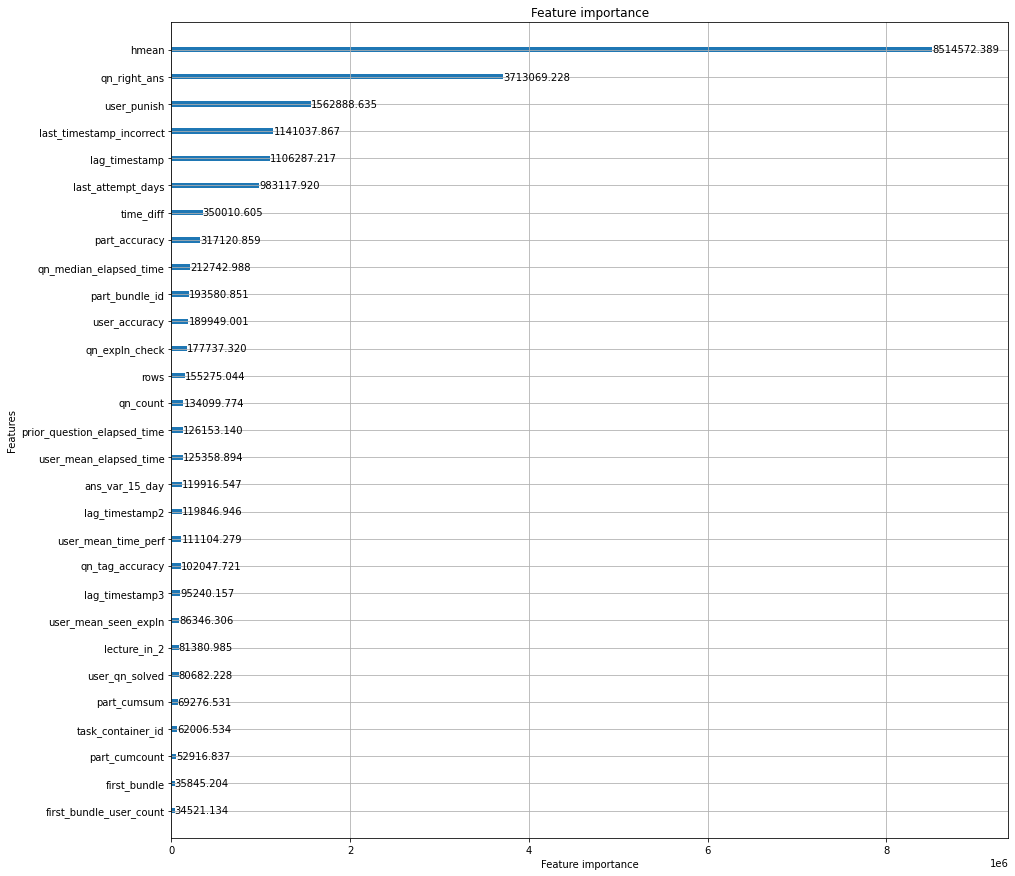

In [108]:
fig,ax = plt.subplots(figsize=(15,15))
lgb.plot_importance(model, ax=ax,importance_type = 'gain')
plt.show()

In [111]:
drop_cols = ['first_bundle','first_bundle_user_count']

In [116]:
lgb_train = lgb.Dataset(train.drop(columns=drop_cols),train_y)
lgb_eval = lgb.Dataset(valid.drop(columns=drop_cols),valid_y,reference=lgb_train)

model = lgb.train(
    params3, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=10,
    num_boost_round=100000,
    early_stopping_rounds=10
)

del lgb_train
del lgb_eval
gc.collect()

Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.782338	valid_1's auc: 0.778672
[20]	training's auc: 0.786798	valid_1's auc: 0.782729
[30]	training's auc: 0.790226	valid_1's auc: 0.785934
[40]	training's auc: 0.792745	valid_1's auc: 0.788193
[50]	training's auc: 0.794514	valid_1's auc: 0.789642
[60]	training's auc: 0.795866	valid_1's auc: 0.790595
[70]	training's auc: 0.796926	valid_1's auc: 0.791223
[80]	training's auc: 0.797796	valid_1's auc: 0.791702
[90]	training's auc: 0.798545	valid_1's auc: 0.792045
[100]	training's auc: 0.799207	valid_1's auc: 0.792342
[110]	training's auc: 0.799844	valid_1's auc: 0.792553
[120]	training's auc: 0.800412	valid_1's auc: 0.792735
[130]	training's auc: 0.800993	valid_1's auc: 0.792894
[140]	training's auc: 0.801517	valid_1's auc: 0.793042
[150]	training's auc: 0.802028	valid_1's auc: 0.793186
[160]	training's auc: 0.802489	valid_1's auc: 0.793247
[170]	training's auc: 0.802924	valid_1's auc: 0.7933
[180]	training'

254

In [117]:
train_columns = list(train.drop(columns=drop_cols).columns)

In [126]:
train.last_timestamp_incorrect.median()

177.01499938964844

In [ ]:
# fig,ax = plt.subplots(figsize=(15,15))
# lgb.plot_importance(model, ax=ax,importance_type = 'gain')
# plt.show()

In [121]:
# train_columns = list(train.columns)
with open('model_inc.pickle','wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('train_columns_inc.pickle','wb') as handle:
    pickle.dump(train_columns,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
drop_cols = ['user_qn_acc']

In [ ]:
lgb_train = lgb.Dataset(train.drop(columns=drop_cols),train_y)
lgb_eval = lgb.Dataset(valid.drop(columns=drop_cols),valid_y,reference=lgb_train)

model = lgb.train(
    params2, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=10,
    num_boost_round=100000,
    early_stopping_rounds=10
)

del lgb_train
del lgb_eval
gc.collect()

In [ ]:
fig,ax = plt.subplots(figsize=(15,15))
lgb.plot_importance(model, ax=ax,importance_type = 'gain')
plt.show()

In [ ]:
# train_columns = list(train.drop(columns = drop_cols).columns)
# with open('model.pickle','wb') as handle:
#     pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('train_columns.pkl','wb') as handle:
#     pickle.dump(train_columns,handle,protocol=pickle.HIGHEST_PROTOCOL)

# DON'T RUN BEYOND THIS POINT

#### Create validation set

In [ ]:
valid_df = data.groupby('user_id').tail(5)
# data = data[~data.index.isin(valid_df.index)]

In [ ]:
del data

### Training

In [ ]:
# train = data.groupby('user_id').tail(18)
# train = train[['user_id','content_id','task_container_id','answered_correctly',
#             'prior_question_elapsed_time','user_qn_solved', 'attempts',
#             'user_accuracy','mean_seen_expln','mean_elapsed_time','mean_time_perf']]
# train.user_qn_solved = (train.user_qn_solved/np.median(user_dict.user_qn_solved)).astype('float32')
# train = train.merge(questions,left_on="content_id",right_index=True,how="left")
# train.drop(columns = ['content_id','user_id'],inplace=True)
# train['right_answers'] = (train['right_answers']/train['question_count']).astype('float32')
# train['qn_expln_check'] = (train['qn_expln_check']/train['question_count']).astype('float32')
# train['qn_median_elapsed_time'] = (train['qn_median_elapsed_time']/train['question_count']).astype('float32')
# train['question_count'] = (train['question_count']/np.median(questions.question_count)).astype('float32')
# train['hmean'] = 2*((train['right_answers']*train['user_accuracy']/10000)/(train['right_answers'] + train['user_accuracy']/10000))
# train = train.drop(columns='part')
# train_y = train['answered_correctly']
# train.drop(columns = 'answered_correctly', inplace=True)

In [ ]:
# valid_df.user_qn_solved = (valid_df.user_qn_solved/np.median(user_dict.user_qn_solved)).astype('float32')
# valid_df = valid_df.merge(questions,left_on="content_id",right_index=True,how="left")
# valid_df.drop(columns = ['content_id','user_id'],inplace=True)
# valid_df['right_answers'] = (valid_df['right_answers']/valid_df['question_count']).astype('float32')
# valid_df['qn_expln_check'] = (valid_df['qn_expln_check']/valid_df['question_count']).astype('float32')
# valid_df['qn_median_elapsed_time'] = (valid_df['qn_median_elapsed_time']/valid_df['question_count']).astype('float32')
# valid_df['question_count'] = (valid_df['question_count']/np.median(questions.question_count)).astype('float32')
# valid_df['hmean'] = 2*((valid_df['right_answers']*valid_df['user_accuracy']/10000)/(valid_df['right_answers'] + valid_df['user_accuracy']/10000))
# valid_df = valid_df.drop(columns='part')
# valid_y = valid_df['answered_correctly']
# valid_df.drop(columns = 'answered_correctly', inplace=True)
# valid_df = valid_df[train.columns]

### Optuna Training

In [ ]:
# import optuna
# from lightgbm import LGBMClassifier
# from optuna.samplers import TPESampler
# from optuna import Trial

In [ ]:
# sampler = TPESampler(seed=666)

# def create_model(trial):
#     num_leaves = trial.suggest_int("num_leaves", 2, 50)
#     n_estimators = trial.suggest_int("n_estimators", 20, 300)
#     max_depth = trial.suggest_int('max_depth', 3, 9)
#     min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)
#     learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
#     min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)
#     bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)
#     feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)
# #     max_bin = trial.suggest_int('max_bin',20,90)
#     subsample = trial.suggest_uniform('subsample', 0.01, 1.0)
    
#     model = LGBMClassifier(
#         num_leaves=num_leaves,
#         n_estimators=n_estimators, 
#         max_depth=max_depth, 
#         min_child_samples=min_child_samples, 
#         min_data_in_leaf=min_data_in_leaf,
#         learning_rate=learning_rate,
#         feature_fraction=feature_fraction,
#         max_bin = 63,
#         subsample = subsample,
#         random_state=666,
#         )
    
#     return model

# def objective(trial):
#     model = create_model(trial)
#     model.fit(train, train_y)
#     preds = model.predict_proba(valid_df)[:,1]
#     score = roc_auc_score(valid_y, preds)
#     return score

# study = optuna.create_study(direction="maximize", sampler=sampler, study_name='lgbm_optuna1')
# study.optimize(objective, n_trials=50)

# opt_params = study.best_params
# opt_params['random_state'] = 666
# print(opt_params)

### Baynesian Optimisation

In [ ]:
# from bayes_opt import BayesianOptimization
# from skopt  import BayesSearchCV 

In [ ]:
# def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=30, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
#     # prepare data
#     train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
#     # parameters
#     def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample, min_child_samples):
#         params = {'objective':'binary', 'metric':'auc'}
#         params['learning_rate'] = max(min(learning_rate, 1), 0)
#         params["num_leaves"] = int(round(num_leaves))
#         params['feature_fraction'] = max(min(feature_fraction, 1), 0)
#         params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
#         params['max_depth'] = int(round(max_depth))
#         params['max_bin'] = int(round(max_depth))
#         params['min_data_in_leaf'] = int(round(min_data_in_leaf))
#         params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
#         params['subsample'] = max(min(subsample, 1), 0)
#         params['min_child_samples'] = int(min_child_samples)
#         cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
#         return max(cv_result['auc-mean'])
    
#     lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.001, 0.99),
#                                             'num_leaves': (15, 80),
#                                             'feature_fraction': (0.1, 0.9),
#                                             'bagging_fraction': (0.01, 1),
#                                             'max_depth': (5, 30),
#                                             'max_bin':(20,90),
#                                             'min_data_in_leaf': (20, 80),
#                                             'min_sum_hessian_in_leaf':(0,100),
#                                            'subsample': (0.01, 1.0), 
#                                             'min_child_samples':(100,1200),}, random_state=200,)
    
#     lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
#     model_auc=[]
#     for model in range(len( lgbBO.res)):
#         model_auc.append(lgbBO.res[model]['target'])
    
#     # return best parameters
#     return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']


# study = optuna.create_study(direction="maximize", sampler=sampler, study_name='lgbm_optuna1')
# study.optimize(objective, n_trials=50)
# opt_params = bayes_parameter_opt_lgb(train, train_y, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)

#### Using LightGBM for testing

In [ ]:
# import lightgbm as lgb

# params = {
#     'objective': 'binary',
#     'boosting' : 'gbdt',
#     'max_bin': 800,
#     'learning_rate': 0.0175,
#     'num_leaves': 80
# }

# params = {'bagging_fraction': 0.8088997672367625,
#  'feature_fraction': 0.4460624552859159,
#  'learning_rate': 0.21296248521966887,
#  'max_bin': 44,
#  'max_depth': 20,
#  'min_data_in_leaf': 41,
#  'min_sum_hessian_in_leaf': 59.34004640105193,
#  'num_leaves': 53,
#  'subsample': 0.36725203786857175,
#  'objective': 'binary',
#  'metric': 'auc',
#  'is_unbalance': True,
#  'boost_from_average': False}

In [ ]:
# lgb_train = lgb.Dataset(train.drop(columns = 'mean_time_perf'),train_y)
# lgb_eval = lgb.Dataset(valid_df.drop(columns = 'mean_time_perf'),valid_y,reference=lgb_train)

# model = lgb.train(
#     params, lgb_train,
#     valid_sets=[lgb_train, lgb_eval],
#     verbose_eval=10,
#     num_boost_round=100000,
#     early_stopping_rounds=10
# )

In [ ]:
# y_pred = model.predict(valid_df)
# y_true = np.array(valid_y)
# roc_auc_score(y_true, y_pred)

In [ ]:
# lgb.plot_importance(model, importance_type = 'gain')
# plt.show()